# Imports | Reads | Filter Patients

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [2]:
# Read the stroke_diagnosis.csv file
df = pd.read_csv("CSV\imports\o05_30_percent_filled_dataset.csv")

In [3]:
"""
Choose patients by los and Time Zone
"""

# Reorder hospital_expire_flag column
column_order = list(df.columns)
column_order.remove('los')  # Remove 'flag' from the original position
column_order.append('los')  # Add 'flag' to the end

# Reindex the DataFrame
df = df.reindex(columns=column_order)

# Filter icu stay less than 10 days
df = df[df['los'] < 10]

# Filter Time Zone
#df = df[df['Time_Zone'] == 16]

# Separate Train - Test Sets

In [4]:
# Set training percentage. The difference goes to test set
training_percentage = 0.7

# It's already sorted. Just for precaution. Sort by 'subject_id' and 'Time_Zone')
df = df.sort_values(by=['subject_id', 'Time_Zone'])

# Calculate the total number of unique subject IDs
unique_subject_ids = df['subject_id'].nunique()

# Calculate the number of unique subject IDs to include in the training set
train_subject_ids_count = int(training_percentage * unique_subject_ids)

# Initialize variables to track the number of subject IDs included in the training set
subject_ids_in_training = 0

# Initialize empty DataFrames for the training and test sets
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

# Iterate through the sorted DataFrame
for subject_id, subject_data in df.groupby('subject_id'):
    if subject_ids_in_training < train_subject_ids_count:
        # Add this subject's data to the training set
        train_df = pd.concat([train_df, subject_data])
        subject_ids_in_training += 1
    else:
        # Add this subject's data to the test set
        test_df = pd.concat([test_df, subject_data])

# Reset the index of the resulting DataFrames
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# I'm going to use those numbers as the split point in rapidminer filter operator
#display("The last row of the training set is -> " + str(train_df.tail(1)["row_count"].values[0]))

C:\Users\dimop\AppData\Local\Temp\ipykernel_16560\1309977842.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, subject_data])
C:\Users\dimop\AppData\Local\Temp\ipykernel_16560\1309977842.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, subject_data])


In [5]:
"""
Prepaire the training and test set
in encoding level and set labels
"""

# Concatenate train_df and test_df for consistent encoding of categorical variables
combined_df = pd.concat([train_df, test_df], axis=0)

# Encode categorical variables
categorical_cols = ['gender', 'language', 'marital_status', 'race']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols)

# Convert 'age' column to numeric type
combined_df_encoded['age'] = pd.to_numeric(combined_df_encoded['age'], errors='coerce')

# Convert 'hospital_expire_flag' column to boolean type
combined_df_encoded['hospital_expire_flag'] = combined_df_encoded['hospital_expire_flag'].astype(bool)


# Split the dataframe at the original row index (before concatenation)
combined_df_encoded_train = combined_df_encoded.iloc[:len(train_df)]
combined_df_encoded_test = combined_df_encoded.iloc[len(train_df):]

# Split data into features and target variable again
X_train = combined_df_encoded_train.drop(['row_count', 'subject_id', 'hadm_id', 'Time_Zone', 'los'], axis=1)
y_train = combined_df_encoded_train['los']
X_test = combined_df_encoded_test.drop(['row_count', 'subject_id', 'hadm_id', 'Time_Zone', 'los'], axis=1)
y_test = combined_df_encoded_test['los']

# Default XGBoost and Manual HyperParameter Adjustment

In [6]:
# Default XGBoost Model
#model = xgb.XGBRegressor(objective='reg:squarederror')

# Stand Alone HyperParameter
#model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.06999999999999999)
#model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.06999999999999999, max_depth=4)
#model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.06999999999999999, max_depth=4, reg_lambda=9.5)
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.06999999999999999, max_depth=4, reg_lambda=9.5, reg_alpha=8.6)

model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

In [7]:
# Metrics
print("Mean Square Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
r2 = r2_score(y_test, y_pred) * 100
print(f"R-squared (R2): {r2:.2f} %")

# MSLE calculation must not have negative values in y_test and y_pred
try:
    msle = mean_squared_log_error(y_test, y_pred)
    print("Mean Squared Logarithmic Error (MSLE):", msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

Mean Square Error (MSE): 2.3493764059383326
Mean Absolute Error (MAE): 1.1017368400673646
Root Mean Squared Error (RMSE): 1.5327675642243779
R-squared (R2): 59.27 %
Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


# Most important features

In [8]:
# Get feature importances
most_important_df = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
most_important_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': most_important_df})

# Sort the DataFrame by feature importance in descending order
most_important_df = most_important_df.sort_values(by='Importance', ascending=False)

# Scale the importance
most_important_df['Importance'] *= 100000

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(most_important_df.head(top_n))

Top 20 most important features:
                                        Feature    Importance
92                                Spont Vt (mL)  10777.653754
98              Tidal Volume (spontaneous) (mL)   6248.226762
5                                            pH   4357.198626
72                                PH (dipstick)   4094.316065
45                                         pH.1   3725.869209
202  Arterial Blood Pressure Alarm - Low (mmHg)   2780.803479
121                                    Eye Care   2631.921135
79                                PH (Arterial)   2357.274853
208                Arterial Line Zero/Calibrate   2341.152541
153               High risk (>51) interventions   1863.489114
46                             Specific Gravity   1609.710231
94                            Daily Weight (kg)   1459.408458
183                         Pain Level Response   1347.286999
138                          ICU Consent Signed   1199.280657
9                                     

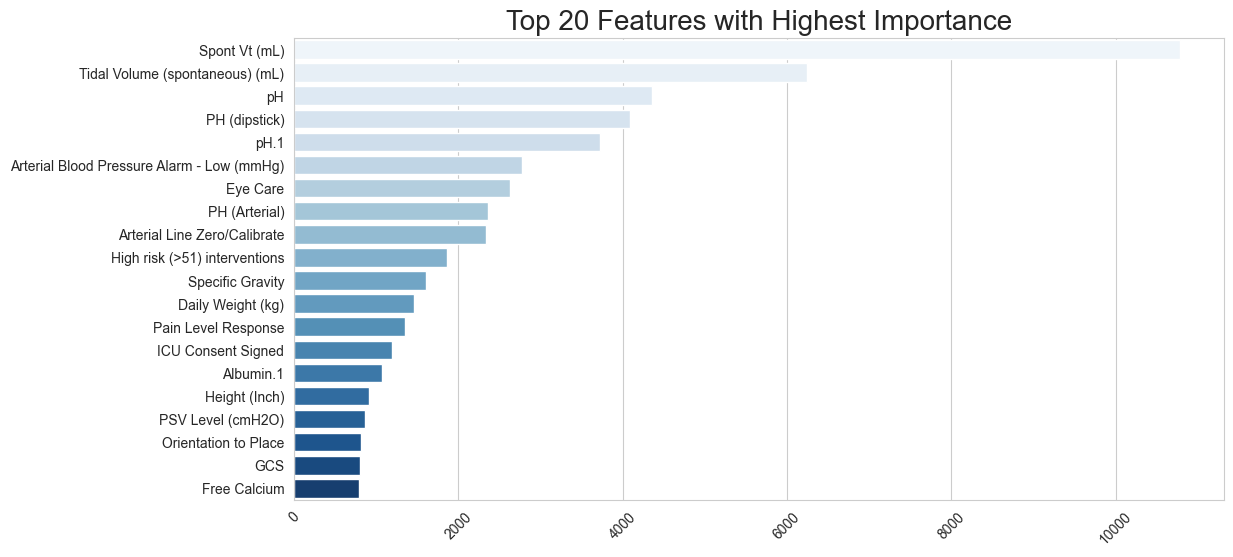

In [11]:
# Set seaborn style and remove gridlines
sns.set_style("whitegrid")

# Top 10 most important features
top_10_features = most_important_df.head(20)

# Plotting
plt.figure(figsize=(12, 6))  # Reduce figure size
plot = sns.barplot(x='Importance', y='Feature', data=top_10_features, hue='Feature', palette="Blues", legend=False)

# Reduce font size slightly 
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.title('Top 20 Features with Highest Importance', fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.ylabel('')
plt.xlabel('')

# Save the plot in high resolution
plt.savefig('plots/top_20_most_important_features.jpeg', dpi=300)
plt.show()

# Stand Alone Hyperparameter

In [ ]:
"""
Testing field
"""

# Define the hyperparameter grid
param_grid = {
    #'learning_rate': np.arange(0.01, 1.00, 0.01),  # Learning rate from 0.01 to 0.51 with step 0.01
    'learning_rate': [0.06999999999999999], # Learning rate set value
    #------------------------------------------------
    #'max_depth': np.arange(1, 11, 1),  # Max depth from 1 to 10 with step 1
    'max_depth': [4], # Max depth set value
    #------------------------------------------------
    #'lambda': np.arange(0.0, 10.0, 0.1),  # L2 from 0.0 to 10.0 with step 0.1
    'lambda': [9.5], # L2 set value
    #------------------------------------------------
    #'alpha': np.arange(0.0, 10.0, 0.1),  # L1 regularization from 0.0 to 10.0 with step 0.1
    'alpha': [8.6], # L1 set value
    #------------------------------------------------
    #'n_estimators': np.arange(1, 100, 1), # Number of trees from 1 to 100 with step 1
    #'n_estimators': [],  # Number of trees
    #-------------------------------------------------
    #'gamma': np.arange(0.0, 1.0, 0.1), # Minimum loss reduction required to make a further partition on a leaf node
    #'gamma': [0, 0.1, 0.2]  # Minimum loss reduction value
}

# Create a grid search object
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                            param_grid=param_grid,
                            cv=5,  # Number of folds in cross-validation
                            scoring='neg_mean_squared_error',  # Scoring metric
                            verbose=1,  # Controls the verbosity
                            n_jobs=-1)  # Number of jobs to run in parallel (-1: all processors)

# Search for best hyperparameters
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Predict on test set using the best model
y_pred_best_stand_alone = best_model.predict(X_test)

# Best model evaluation
print("Mean Square Error (MSE):", mean_squared_error(y_test, y_pred_best_stand_alone))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_best_stand_alone))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred_best_stand_alone, squared=False))
print("R-squared (R2):", r2_score(y_test, y_pred_best_stand_alone))

# MSLE calculation must not have negative values in y_test and y_pred
try:
    msle = mean_squared_log_error(y_test, y_pred_best_stand_alone)
    print("Mean Squared Logarithmic Error (MSLE):", msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Set all HyperParameters & Train Model

In [ ]:
cross_val=10,  # Number of folds in cross-validation
score_metric='neg_mean_squared_error',  # Scoring metric
verbosity=1,  # Controls the verbosity
processors_jobs=-1)  # Number of jobs to run in parallel (-1: all processors)

# Learning Rate HyperParameter
param_grid_learning_rate = {
    'learning_rate': np.arange(0.01, 1.01, 0.01),  # Learning rate from 0.01 to 1.00 with step 0.01
}

# Create a grid search object for learning rate
grid_search_learning_rate = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                            param_grid=param_grid_learning_rate,
                            cv=cross_val,  # Number of folds in cross-validation
                            scoring=score_metric,  # Scoring metric
                            verbose=verbosity,  # Controls the verbosity
                            n_jobs=processors_jobs)  # Number of jobs to run in parallel (-1: all processors)

# Search best learning rate
grid_search_learning_rate.fit(X_train, y_train)

# Best learning rate
best_learning_rate = grid_search_learning_rate.best_params_['learning_rate']

#----------------------------------------------------------------------------------------------------

# Max Depth HyperParameter
param_grid_max_depth = {
    'max_depth': np.arange(1, 11, 1),  # Max depth from 1 to 10 with step 1
}

# Create a grid search object for max depth
grid_search_max_depth = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate),
                            param_grid=param_grid_max_depth,
                            cv=cross_val,  # Number of folds in cross-validation
                            scoring=score_metric,  # Scoring metric
                            verbose=verbosity,  # Controls the verbosity
                            n_jobs=processors_jobs)  # Number of jobs to run in parallel (-1: all processors)

# Search best max depth
grid_search_max_depth.fit(X_train, y_train)

# Best max depth
best_max_depth = grid_search_max_depth.best_params_['max_depth']

#----------------------------------------------------------------------------------------------------

# L2 HyperParameter
param_grid_lambda = {
    'reg_lambda': np.arange(0.0, 10.1, 0.1),  # Lambda (L2 regularization) from 0.0 to 10.0 with step 0.1
}

# Create a grid search object for lambda
grid_search_lambda = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate, max_depth=best_max_depth),
                            param_grid=param_grid_lambda,
                            cv=cross_val,  # Number of folds in cross-validation
                            scoring=score_metric,  # Scoring metric
                            verbose=verbosity,  # Controls the verbosity
                            n_jobs=processors_jobs)  # Number of jobs to run in parallel (-1: all processors)

# Search for best L2
grid_search_lambda.fit(X_train, y_train)

# Best L2
best_lambda = grid_search_lambda.best_params_['reg_lambda']

#----------------------------------------------------------------------------------------------------

# L1 HyperParameter
param_grid_alpha = {
    'reg_alpha': np.arange(0.0, 10.1, 0.1),  # Alpha (L1 regularization) from 0.0 to 10.0 with step 0.1
}

# Create a grid search object for alpha
grid_search_alpha = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate, max_depth=best_max_depth, reg_lambda=best_lambda),
                            param_grid=param_grid_alpha,
                            cv=cross_val,  # Number of folds in cross-validation
                            scoring=score_metric,  # Scoring metric
                            verbose=verbosity,  # Controls the verbosity
                            n_jobs=processors_jobs)  # Number of jobs to run in parallel (-1: all processors)

# Search for best L1
grid_search_alpha.fit(X_train, y_train)

# Best L1
best_alpha = grid_search_alpha.best_params_['reg_alpha']

#----------------------------------------------------------------------------------------------------

# Gamma HyperParameter
param_grid_gamma = {
    'gamma': np.arange(0.0, 1.1, 0.1),  # Gamma from 0.0 to 1.0 with step 0.1
}

# Create a grid search object for gamma
grid_search_gamma = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate, max_depth=best_max_depth, reg_lambda=best_lambda, alpha=best_alpha),
                            param_grid=param_grid_gamma,
                            cv=cross_val,  # Number of folds in cross-validation
                            scoring=score_metric,  # Scoring metric
                            verbose=verbosity,  # Controls the verbosity
                            n_jobs=processors_jobs)  # Number of jobs to run in parallel (-1: all processors)

# Search for best gamma
grid_search_gamma.fit(X_train, y_train)

# Best gamma
best_gamma = grid_search_gamma.best_params_['gamma']

#----------------------------------------------------------------------------------------------------

# Train the model using the best hyperparameter values
best_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate, max_depth=best_max_depth, reg_lambda=best_lambda, reg_alpha=best_alpha, gamma=best_gamma)
best_model.fit(X_train, y_train)

# Predict on test set using the best model
y_pred_best = best_model.predict(X_test)

# Best model evaluation
print("Mean Square Error (MSE):", mean_squared_error(y_test, y_pred_best))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_best))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred_best, squared=False))
r2 = r2_score(y_test, y_pred_best) * 100
print(f"R-squared (R2): {r2:.2f} %")

# MSLE calculation must not have negative values in y_test and y_pred
try:
    msle = mean_squared_log_error(y_test, y_pred_best)
    print("Mean Squared Logarithmic Error (MSLE):", msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

In [ ]:
print("Best LR", best_learning_rate)
print("Best Max Depth", best_max_depth)
print("Best L2", best_lambda)
print("Best L1", best_alpha)
print("Best Gamma", best_gamma)